In [1]:
try:
    import google.colab  # noqa: F401

    # specify the version of DataEval (==X.XX.X) for versions other than the latest
    %pip install -q dataeval dataeval-plots[plotly] maite-datasets
except Exception:
    pass

In [2]:
import dataeval_plots as dep
import plotly.io as pio
import polars as pl
from maite_datasets.image_classification import CIFAR10

from dataeval import Metadata
from dataeval.bias import Balance, Diversity
from dataeval.core import calculate_stats
from dataeval.flags import ImageStats
from dataeval.selection import Limit, Select, Shuffle

_ = pl.Config.set_tbl_rows(-1)
# Use plotly to render plots
dep.set_default_backend("plotly")
dep.set_default_backend("matplotlib")  # LOL BUMP BUMP

# Use the notebook renderer so JS is embedded
pio.renderers.default = "notebook"

In [3]:
# Load in the CIFAR10 dataset and limit to 20,000 images with random shuffling
cifar10 = Select(CIFAR10("data", image_set="base", download=True), [Limit(20000), Shuffle(seed=0)])
print(cifar10)

Select Dataset
--------------
    Selections: [Limit(size=20000), Shuffle(seed=0)]
    Selected Size: 20000

CIFAR10 Dataset
---------------
    Transforms: []
    Image Set: base
    Metadata: {'id': 'CIFAR10_base', 'index2label': {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}, 'split': 'base'}
    Path: /builds/jatic/aria/dataeval/docs/source/notebooks/data/cifar10
    Size: 60000


In [4]:
metadata = Metadata(cifar10)
print(f"Factor names: {metadata.factor_names}")

Factor names: ['batch_num', 'id']


In [5]:
# Balance at index 0 is always class
Balance().evaluate(metadata).balance[2]

factor_name,mi_value
cat,f64
"""id""",0.001054


In [6]:
# Calculate pixel and visual statistics
calc_results = calculate_stats(cifar10, stats=ImageStats.PIXEL | ImageStats.VISUAL)

# Append the factors to the metadata
metadata.add_factors(calc_results["stats"])

In [7]:
# Exclude the id and batch_num as it is not a relevant factor for bias analysis
metadata.exclude = ["id", "batch_num"]

# Provide binning for the continuous statistical factors using 5 uniform-width bins for each factor
keys = ("mean", "std", "var", "skew", "kurtosis", "entropy", "brightness", "darkness", "sharpness", "contrast", "zeros")
metadata.continuous_factor_bins = dict.fromkeys(keys, 5)

In [8]:
balance_output = Balance().evaluate(metadata)

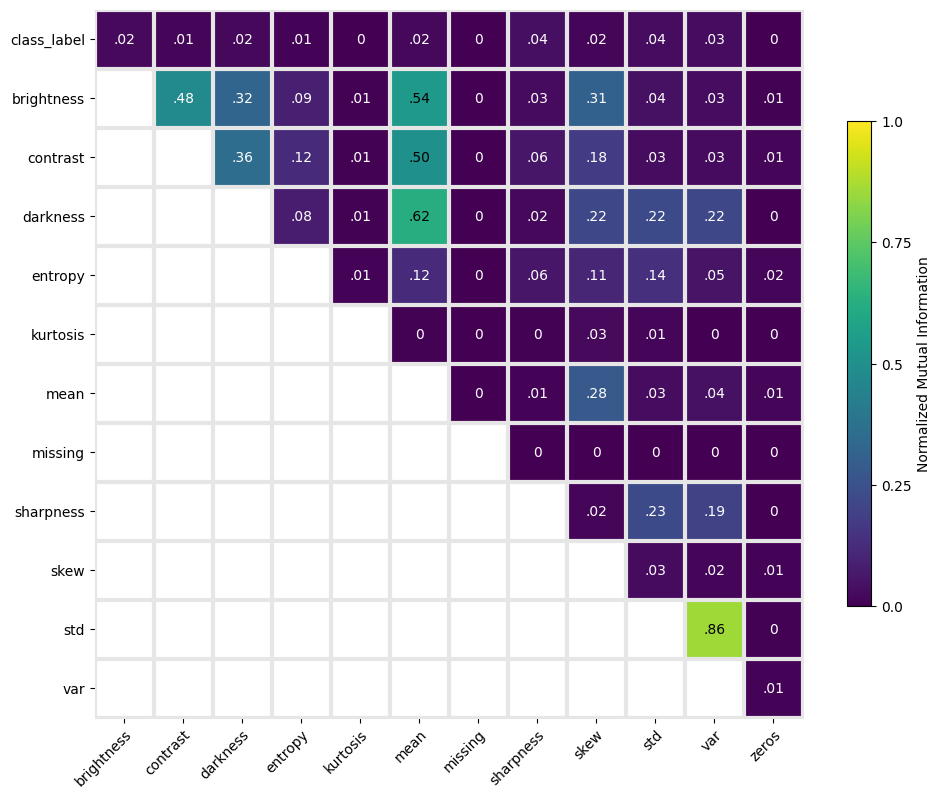

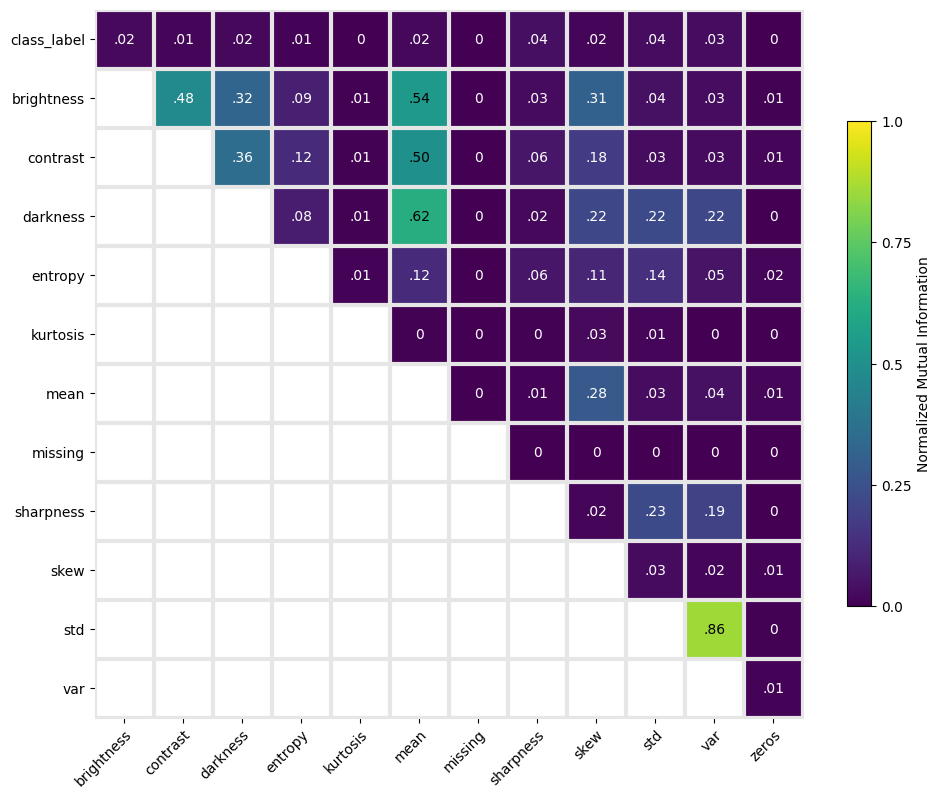

In [9]:
dep.plot(balance_output)

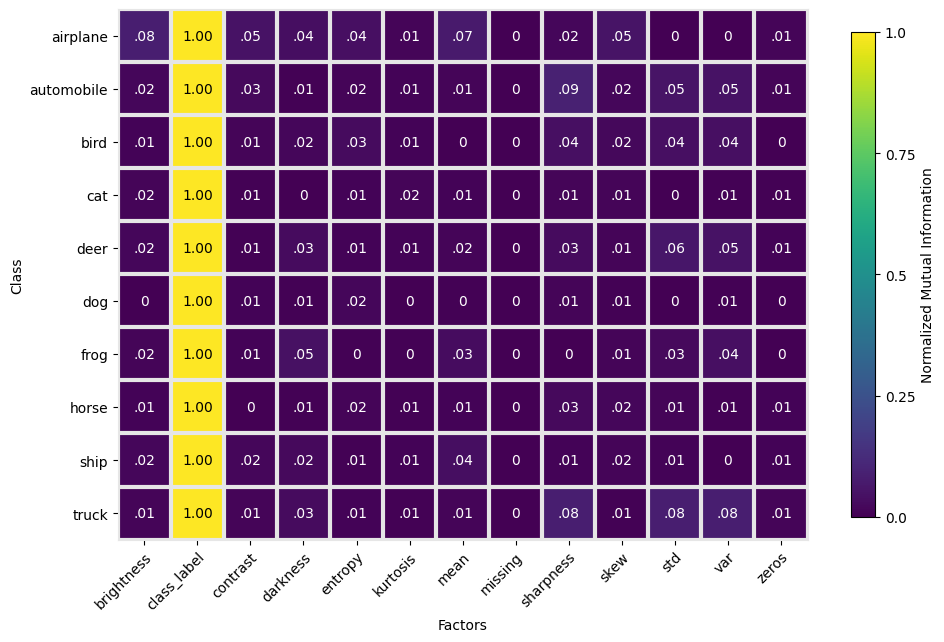

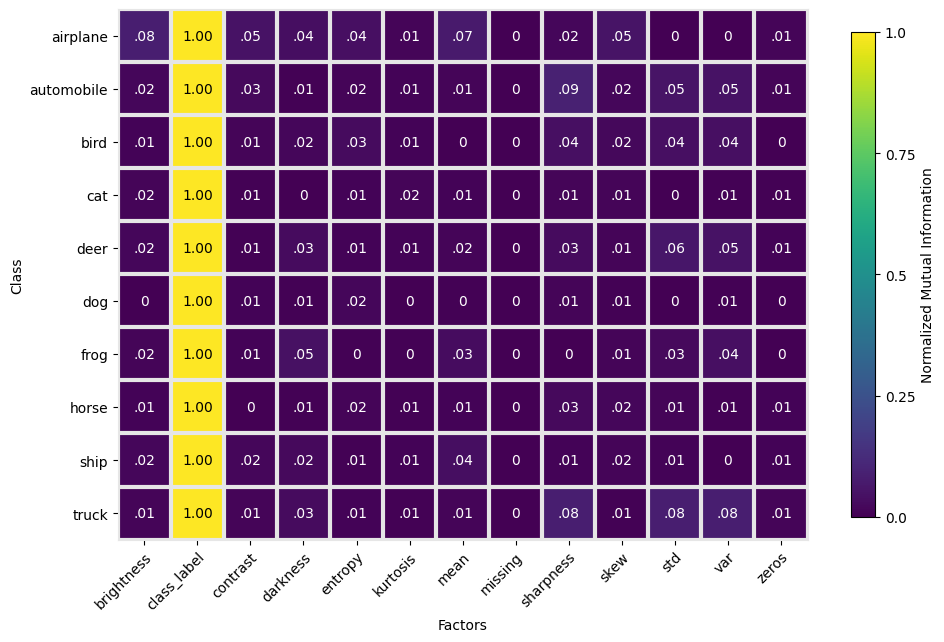

In [10]:
dep.plot(balance_output, plot_classwise=True)

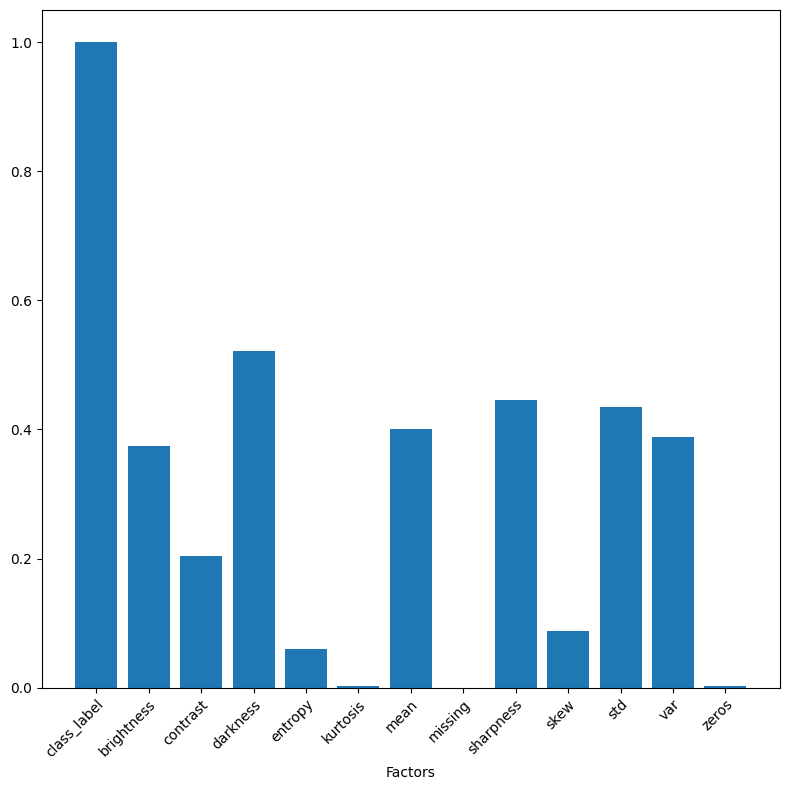

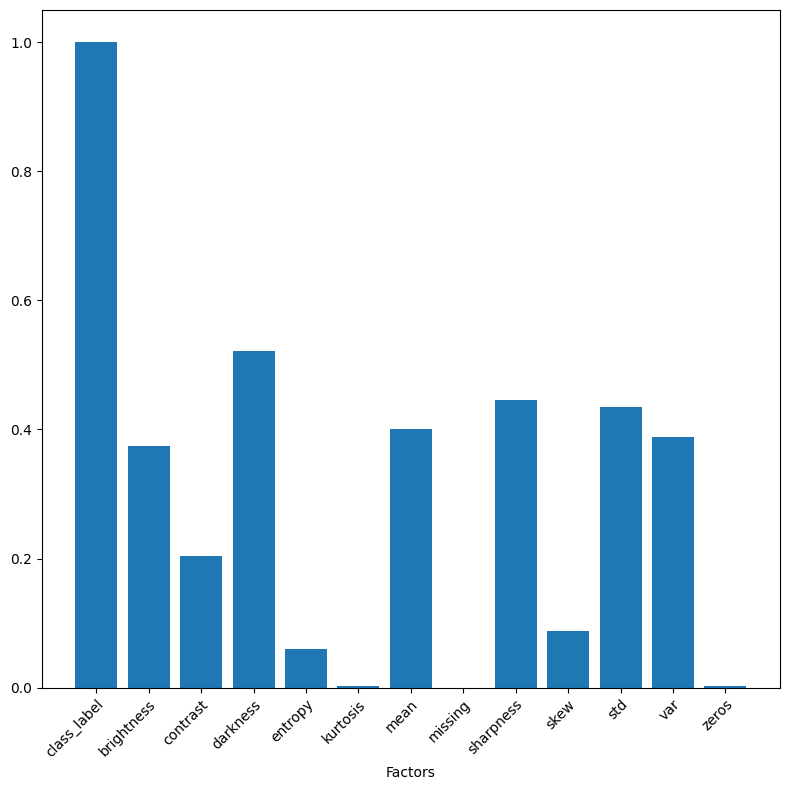

In [11]:
diversity_output = Diversity().evaluate(metadata)
dep.plot(diversity_output)